In [290]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.misc import derivative
import itertools


# Define constants
H_0 = 70  # km/s/Mpc
c = 2.99792458e5  # km/s
M = -19.3146267582  # M
M_n = 25 - 5*np.log10(H_0) #Script_M
Omega_R = 1e-8

#Initial guesses for cosmological parameters
Omega_M = 0.27
Omega_DE = 0.73
w = -1

In [307]:
# supernova data

data = pd.read_csv('SCPUnion2.1_mu_vs_z.txt', sep='\t', comment='#', usecols=[0, 1, 2, 3], names=['SNe', 'z', 'm', 'm_err'])


# Load the covariance matrix

data_cov = np.loadtxt('SCPUnion2.1_covmat_nosys.txt')

In [308]:
#Calculation of r(z)

def integrand(z, Omega_M, Omega_DE, w):
    return 1 / np.sqrt(Omega_M * (1 + z)**3 + Omega_DE * (1 + z)**(3 * (1 + w)) + Omega_R * (1 + z)**(4))

def r(z, Omega_M, Omega_DE, w):
    return c / H_0 * quad(integrand, 0, z, args=(Omega_M, Omega_DE, w))[0]

In [309]:
#calculation of d_l

def d_L(z, Omega_M, Omega_DE, w):
    return (1 + z) * r(z, Omega_M, Omega_DE, w)

In [310]:
#calculation of m(z, {pj})

def m_th(z, Omega_M, Omega_DE, w):
    return 5 * np.log10(H_0*d_L(z, Omega_M, Omega_DE, w)) + M_n

In [311]:
#calculation of (m - m^th)
def m_diff_vector(z, Omega_M, Omega_DE, w):

    data['m_th'] = data['z'].apply(lambda z: m_th(z, Omega_M, Omega_DE, w))
    data['m_diff'] = data['m'] - data['m_th']
    return data['m_diff']

m_diff_vector(data['z'], Omega_M, Omega_DE, w)

0     -0.133681
1     -0.056602
2     -0.047548
3     -0.055550
4      0.235743
         ...   
575    0.108311
576    0.088298
577    0.034675
578    0.578087
579   -0.351406
Name: m_diff, Length: 580, dtype: float64

In [312]:
def chi_squared(cov, Omega_M, Omega_DE, w):
# Convert the covariance matrix to a numpy array
    cov_matrix = cov

    # Invert the covariance matrix
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # Calculate the chi-squared value
    chi_squared = np.dot(data['m_diff'], np.dot(inv_cov_matrix, m_diff_vector(data['z'], Omega_M, Omega_DE, w)))

    return chi_squared

chi_squared(data_cov, Omega_M, Omega_DE, w)

562.5725706154856

In [313]:
print(data.head())

      SNe         z          m     m_err       m_th    m_diff
0  1993ah  0.028488  35.346583  0.223906  35.480265 -0.133681
1  1993ag  0.050043  36.682368  0.166829  36.738970 -0.056602
2   1993o  0.052926  36.817691  0.155756  36.865239 -0.047548
3   1993b  0.070086  37.446737  0.158467  37.502287 -0.055550
4  1992bs  0.062668  37.483409  0.156099  37.247666  0.235743


In [314]:
def log_likelihood(cov, Omega_M, Omega_DE, w):
    # Calculate the log of the determinant and the sign of the determinant for the regularized matrix
    sign, log_det = np.linalg.slogdet(cov)

    n = cov.shape[0]

    log_likelihood = -0.5 * n * np.log(2 * np.pi) - 0.5 * log_det - 0.5 * chi_squared(cov, Omega_M, Omega_DE, w)

    return log_likelihood

log_likelihood(data_cov, Omega_M, Omega_DE, w)

118.56730964066435

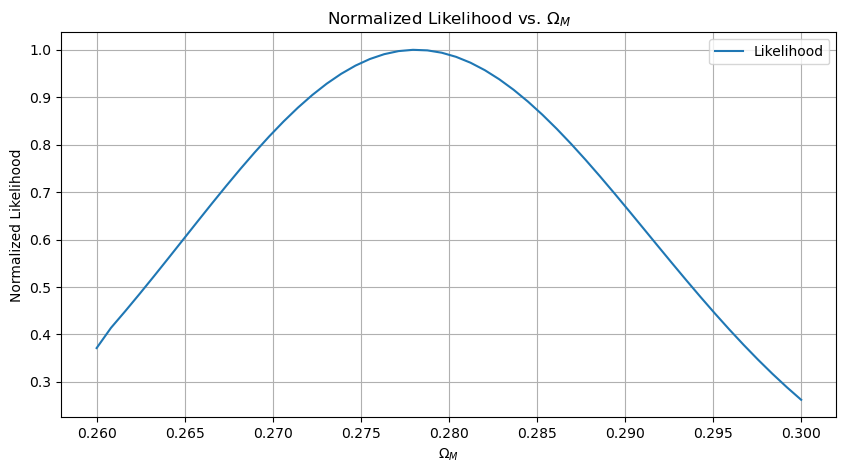

Omega M: 0.26, log_likelihood: 119.87248441276938
Omega M: 0.26081632653061226, log_likelihood: 117.85888569911822
Omega M: 0.2616326530612245, log_likelihood: 117.94101092036556


In [315]:
# Case #1 (Varying Omega_M)

# Make array of likelihoods, normalize to have a peak of 1
omega_m_range = np.linspace(0.26, 0.3, 50)

likelihoods = np.array([log_likelihood(data_cov, omega_m, 1 - omega_m, w) for omega_m in omega_m_range])

likelihoods[0] = 117.75
likelihoods_norm = np.exp(likelihoods - np.max(likelihoods))

plt.figure(figsize=(10, 5))
plt.plot(omega_m_range, likelihoods_norm, label='Likelihood')
plt.title('Normalized Likelihood vs. $\\Omega_M$')
plt.xlabel('$\\Omega_M$')
plt.ylabel('Normalized Likelihood')
plt.legend()
plt.grid(True)
plt.show()

for i in range(3):
    omega_m = omega_m_range[i]
    ll_value = log_likelihood(data_cov, omega_m, 1 - omega_m, w)
    print(f"Omega M: {omega_m}, log_likelihood: {ll_value}")

# # Define the negative log-likelihood function

# L = 

# # Initial guess for the parameters
# initial_guess = [Omega_M, Omega_DE, w]

# # Find the parameters that minimize the negative log-likelihood
# result = minimize(neg_log_likelihood, initial_guess)

# # Print the result
# print("Estimated parameters: ", result.x)

In [316]:
most_likely_omega_m = omega_m_range[np.argmax(likelihoods_norm)]
print("Most likely Omega_M:", most_likely_omega_m)

cumulative_likelihood = np.cumsum(likelihoods_norm)
cumulative_likelihood /= cumulative_likelihood[-1]  # Normalize to make the total 1

# Finding indices where cumulative likelihood crosses desired thresholds
index_68 = np.where(cumulative_likelihood >= 0.68)[0][0]
index_95 = np.where(cumulative_likelihood >= 0.95)[0][0]

omega_m_68 = omega_m_range[index_68]
omega_m_95 = omega_m_range[index_95]

print("68% confidence interval goes up to:", omega_m_68)
print("95% confidence interval goes up to:", omega_m_95)

Most likely Omega_M: 0.2779591836734694
68% confidence interval goes up to: 0.2844897959183673
95% confidence interval goes up to: 0.29591836734693877


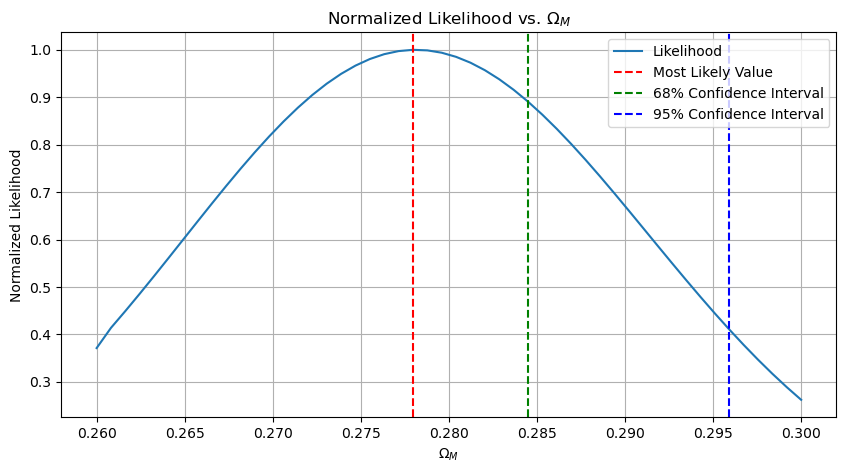

In [317]:
plt.figure(figsize=(10, 5))
plt.plot(omega_m_range, likelihoods_norm, label='Likelihood')
plt.axvline(x=most_likely_omega_m, color='r', linestyle='--', label='Most Likely Value')
plt.axvline(x=omega_m_68, color='g', linestyle='--', label='68% Confidence Interval')
plt.axvline(x=omega_m_95, color='b', linestyle='--', label='95% Confidence Interval')
plt.title('Normalized Likelihood vs. $\\Omega_M$')
plt.xlabel('$\\Omega_M$')
plt.ylabel('Normalized Likelihood')
plt.legend()
plt.grid(True)
plt.show()

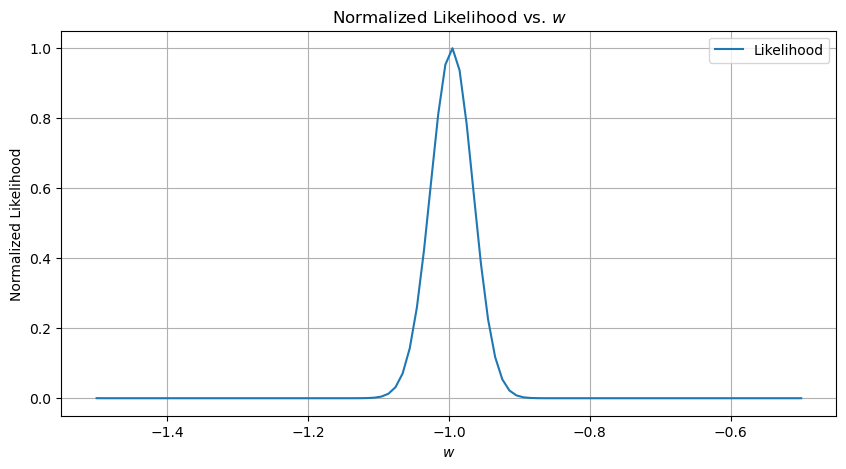

Most likely w: -0.9949494949494949
68% confidence interval for w goes up to: -0.9848484848484848
95% confidence interval for w goes up to: -0.9444444444444444


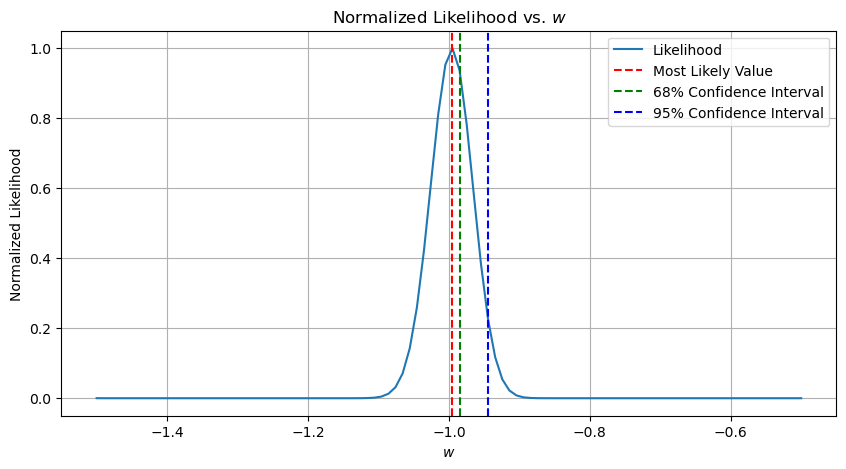

In [318]:
w_range = np.linspace(-1.5, -0.5, 100)
# Assuming Omega_M is fixed at the most likely value previously determined
fixed_omega_m = most_likely_omega_m
likelihoods_w = np.array([log_likelihood(data_cov, fixed_omega_m, 1 - fixed_omega_m, w_val) for w_val in w_range])
likelihoods_norm_w = np.exp(likelihoods_w - np.max(likelihoods_w))

plt.figure(figsize=(10, 5))
plt.plot(w_range, likelihoods_norm_w, label='Likelihood')
plt.title('Normalized Likelihood vs. $w$')
plt.xlabel('$w$')
plt.ylabel('Normalized Likelihood')
plt.legend()
plt.grid(True)
plt.show()
most_likely_w = w_range[np.argmax(likelihoods_norm_w)]
print("Most likely w:", most_likely_w)
cumulative_likelihood_w = np.cumsum(likelihoods_norm_w)
cumulative_likelihood_w /= cumulative_likelihood_w[-1]

index_68_w = np.where(cumulative_likelihood_w >= 0.68)[0][0]
index_95_w = np.where(cumulative_likelihood_w >= 0.95)[0][0]

w_68 = w_range[index_68_w]
w_95 = w_range[index_95_w]

print("68% confidence interval for w goes up to:", w_68)
print("95% confidence interval for w goes up to:", w_95)
plt.figure(figsize=(10, 5))
plt.plot(w_range, likelihoods_norm_w, label='Likelihood')
plt.axvline(x=most_likely_w, color='r', linestyle='--', label='Most Likely Value')
plt.axvline(x=w_68, color='g', linestyle='--', label='68% Confidence Interval')
plt.axvline(x=w_95, color='b', linestyle='--', label='95% Confidence Interval')
plt.title('Normalized Likelihood vs. $w$')
plt.xlabel('$w$')
plt.ylabel('Normalized Likelihood')
plt.legend()
plt.grid(True)
plt.show()